In [1]:
%pip install -Uq langgraph langchain langchain-openai langchain-groq python-dotenv

^C
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# Set the project name for LangSmith

import os

PROJECT_NAME = "LangGraph Course"

os.environ["LANGCHAIN_PROJECT"] = PROJECT_NAME

## Validate the state on interruption

In this section, we will see how to interrupt the flow of your graph on a given moment. Let's suppose that you want to interrupt the flow before the `Tools` node is executed to so you can validate the tool call before executing it. Or maybe you want to verify that the response that a node has produced is what you expected. In this case, you will want to add a `interrupt_before` or `interrupt_after` parameter to the `compile` method.

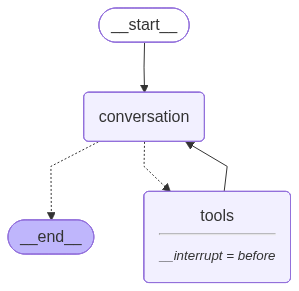

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from IPython.display import Image, display
from langgraph.graph import StateGraph, START
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import SystemMessage

# custom state
# define our tools
def celsius_to_fahrenheit(celsius: float) -> float:
    """
    Convert Celsius to Fahrenheit

    Args:
    celsius: The temperature in Celsius
    """
    return celsius * 9/5 + 32

def get_temperature(city: str) -> float:
    """
    Get the temperature of a city in Celsius

    Args:
    city: The name of the city
    """
    if city.lower() == "berlin":
        return 20
    if city.lower() == "paris":
        return 22
    if city.lower() == "san francisco":
        return 25
    return 30

tools = [celsius_to_fahrenheit, get_temperature]

# define our llm and bind the tools
llm = ChatOpenAI(model="gpt-4o-mini")
#groq_llm = ChatGroq(model="llama-3.1-70b-versatile")
llm_with_tools = llm.bind_tools(tools)

# node
def conversation(state: MessagesState):
    messages = state.get("messages", [])

    system_prompt = """
    You are a helpful assistant. You can tell the user the
    temperature of a city in Celsius and also convert any
    temperature from Celsius to Fahrenheit.""".strip()

    messages = [SystemMessage(content=system_prompt)] + messages

    response_message = llm_with_tools.invoke(messages)

    return {"messages": [response_message]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("conversation", conversation)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "conversation")
builder.add_conditional_edges("conversation", tools_condition)
builder.add_edge("tools", "conversation")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory, interrupt_before=["tools"]) # specify where we want to interrupt the flow

# mermaid graph
display(Image(graph.get_graph().draw_mermaid_png()))


In [4]:
# executing the graph will stop right before getting into the `Tools` node

from langchain_core.messages import HumanMessage

THREAD_ID = "3"

config = {"configurable": {"thread_id": THREAD_ID,}}
input_messages = [
    HumanMessage(content="What is the temperature in Berlin?"),
]

import pprint
for event in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    pprint.pprint(event)
    print("-" * 50)


{'messages': [HumanMessage(content='What is the temperature in Berlin?', additional_kwargs={}, response_metadata={}, id='35c6364a-857a-434d-8373-0b92094f9b60')]}
--------------------------------------------------
{'messages': [HumanMessage(content='What is the temperature in Berlin?', additional_kwargs={}, response_metadata={}, id='35c6364a-857a-434d-8373-0b92094f9b60'),
              AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wfHMeN5TL7KB4OFjiCUFWJyf', 'function': {'arguments': '{"city":"Berlin"}', 'name': 'get_temperature'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 121, 'total_tokens': 135, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcm

In [5]:
# let's see what node is next in the state of the graph

state = graph.get_state(config)
state.next

('tools',)

In [6]:
# We have validated that the tool is okay.
# Now, let's continue execution by passing None as input to the graph within the same thread:

for event in graph.stream(None, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  get_temperature (call_wfHMeN5TL7KB4OFjiCUFWJyf)
 Call ID: call_wfHMeN5TL7KB4OFjiCUFWJyf
  Args:
    city: Berlin
================================= Tool Message =================================
Name: get_temperature

20
================================== Ai Message ==================================

The temperature in Berlin is currently 20°C.


In [7]:
# If you want to check the entire history

state = graph.get_state(config)
for m in state.values.get("messages"):
  m.pretty_print()

================================ Human Message =================================

What is the temperature in Berlin?
================================== Ai Message ==================================
Tool Calls:
  get_temperature (call_wfHMeN5TL7KB4OFjiCUFWJyf)
 Call ID: call_wfHMeN5TL7KB4OFjiCUFWJyf
  Args:
    city: Berlin
================================= Tool Message =================================
Name: get_temperature

20
================================== Ai Message ==================================

The temperature in Berlin is currently 20°C.


## Update the state on interruption

Now that we have seen how to interrupt the flow of the graph, we may want to update it. This can be useful if you want to update a given message in the history or add a new message, for example. Or maybe you want to upadte any other part of the state. We do this by running the method `update_state` on the graph and passing in a dictionary with the elements of the state that we want to update. This is akin to updating the state of the graph with a node, which means that any value you pass into the `update_state` method will go through the reducer (or it will replace the value of that state's property if there is no reducer).

In this example, we have a graph that will interrupt right before entering the conversation node. This means that we can update the state before it goes to our LLM. Let's add an extra message on interruption.

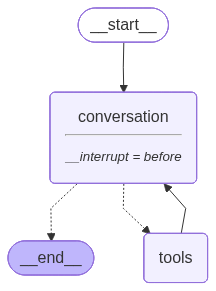

In [8]:
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from IPython.display import Image, display
from langgraph.graph import StateGraph, START
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import SystemMessage

# custom state
# define our tools
def celsius_to_fahrenheit(celsius: float) -> float:
    """
    Convert Celsius to Fahrenheit

    Args:
    celsius: The temperature in Celsius
    """
    return celsius * 9/5 + 32

def get_temperature(city: str) -> float:
    """
    Get the temperature of a city in Celsius

    Args:
    city: The name of the city
    """
    if city.lower() == "berlin":
        return 20
    if city.lower() == "paris":
        return 22
    if city.lower() == "san francisco":
        return 25
    return 30

tools = [celsius_to_fahrenheit, get_temperature]

# define our llm and bind the tools
llm = ChatOpenAI(model="gpt-4o-mini")
#groq_llm = ChatGroq(model="llama-3.1-70b-versatile")
llm_with_tools = llm.bind_tools(tools)

# node
def conversation(state: MessagesState):
    messages = state.get("messages", [])

    system_prompt = """
    You are a helpful assistant. You can tell the user the
    temperature of a city in Celsius and also convert any
    temperature from Celsius to Fahrenheit.""".strip()

    messages = [SystemMessage(content=system_prompt)] + messages

    response_message = llm_with_tools.invoke(messages)

    return {"messages": [response_message]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("conversation", conversation)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "conversation")
builder.add_conditional_edges("conversation", tools_condition)
builder.add_edge("tools", "conversation")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory, interrupt_before=["conversation"])

# mermaid graph
display(Image(graph.get_graph().draw_mermaid_png()))


In [13]:
# run the regular graph

THREAD_ID = "991"

config = {"configurable": {"thread_id": THREAD_ID,}}
input_messages = [
    HumanMessage(content="What is the temperature in berlin?"),
]

for event in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the temperature in berlin?


In [14]:
# now let's update the state with an extra message
graph.update_state(config, {"messages": [
  HumanMessage(content="Don't forget to convert the temperature to Fahrenheit")
]})

{'configurable': {'thread_id': '991',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0a19b0-8208-632c-8001-541ad46b2691'}}

In [15]:
# as you can see, the new message was appended because it went through the `add_messages` reducer

updated_state = graph.get_state(config)
for m in updated_state.values.get("messages"):
  m.pretty_print()

================================ Human Message =================================

What is the temperature in berlin?
================================ Human Message =================================

Don't forget to convert the temperature to Fahrenheit


In [16]:
# the next node in the interrupted flow

updated_state.next

('conversation',)

In [17]:
# continue the flow by passing `None` to the graph

for event in graph.stream(None, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Don't forget to convert the temperature to Fahrenheit
================================== Ai Message ==================================
Tool Calls:
  get_temperature (call_pWEBDlI08yrmp6UCNA9ku4FX)
 Call ID: call_pWEBDlI08yrmp6UCNA9ku4FX
  Args:
    city: Berlin
================================= Tool Message =================================
Name: get_temperature

20


In [18]:
# continue again (we got interruped again before entering the conversation node)

for event in graph.stream(None, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: get_temperature

20
================================== Ai Message ==================================
Tool Calls:
  celsius_to_fahrenheit (call_qVDJOds1e9ucl94tepLw9F3D)
 Call ID: call_qVDJOds1e9ucl94tepLw9F3D
  Args:
    celsius: 20
================================= Tool Message =================================
Name: celsius_to_fahrenheit

68.0


In [19]:
# and once more

for event in graph.stream(None, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: celsius_to_fahrenheit

68.0
================================== Ai Message ==================================

The temperature in Berlin is 20°C, which is 68°F.


In [20]:
# the flow is finished

state = graph.get_state(config)
print(state.next)

()
